<a href="https://colab.research.google.com/github/rrankawat/pytorch-basic/blob/main/05_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Import Libraries

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import time

##### Download MNIST Images and Convert to Tensors

In [194]:
# 4-Dimensions (Images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [195]:
# Train Data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [196]:
# Test Data
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

##### Convolutional and Pooling Layers

In [197]:
# Create a batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [198]:
# Describe convolutional layers
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [199]:
# Grab 1 MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

X_train.shape

torch.Size([1, 28, 28])

In [200]:
# Convert it into 4-D batch
x = X_train.view(1, 1, 28, 28) # batch-1, image-1, 28x28
x.shape

torch.Size([1, 1, 28, 28])

In [201]:
# Perform 1st Conv
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function
x.shape # image-1, filters-6, 26x26

torch.Size([1, 6, 26, 26])

In [202]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel-2, stride-2
x.shape # image-1, filters-6, 13x13 (26 / 2)

torch.Size([1, 6, 13, 13])

In [203]:
# Perform 2nd Conv
x = F.relu(conv2(x)) # Rectified Linear Unit for our activation function
x.shape # image-1, filters-16, 11x11

torch.Size([1, 16, 11, 11])

In [204]:
# Pass through the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel-2, stride-2
x.shape # image-1, filters-16, 5x5 (11 / 2)

torch.Size([1, 16, 5, 5])

##### Model Class

In [205]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
     super().__init__()

     self.conv1 = nn.Conv2d(1, 6, 3, 1)
     self.conv2 = nn.Conv2d(6, 16, 3, 1)

     # Fully connected layers
     self.fc1 = nn.Linear(16 * 5 * 5, 120)
     self.fc2 = nn.Linear(120, 84)
     self.fc3 = nn.Linear(84, 10) # Because we have 10 no of classes

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-view to flatten it out
    X = X.view(-1, 16 * 5 * 5)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [206]:
# Create an instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

##### Train & Test Model

In [207]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [208]:
start_time = time.time()

# Variables to Track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_correct = 0
  tst_correct = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1 # Start our batches at 1
    y_pred = model(X_train) # Get predicted values from training set
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    trn_correct += (predicted == y_train).sum()

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print results
    if b % 600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  # Append to variables after each epoch
  train_losses.append(loss)
  train_correct.append(trn_correct)

  # Test
  with torch.no_grad():
    for X_test, y_test in test_loader:
      y_val = model(X_test)

      predicted = torch.max(y_val.data, 1)[1]
      tst_correct += (predicted == y_test).sum()

    # Append to variables after each epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

current_time = time.time()
total = (current_time - start_time) / 60
print(f'Training Took: {round(total, 2)} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

##### Plots

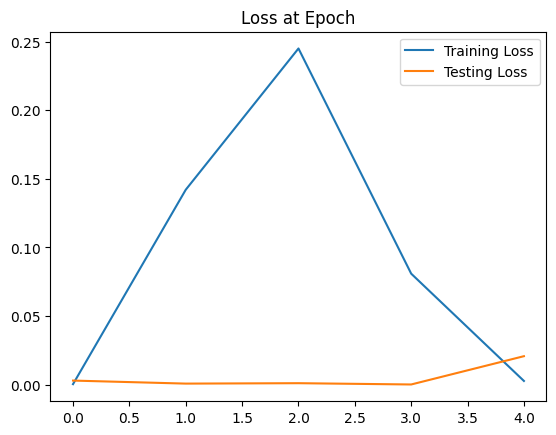

In [209]:
# Graph the loss at epoch
plt.plot([t.item() for t in train_losses], label='Training Loss')
plt.plot([t.item() for t in test_losses], label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

In [210]:
train_correct

[tensor(56257), tensor(58786), tensor(59148), tensor(59313), tensor(59461)]

In [211]:
test_correct

[tensor(9771), tensor(9817), tensor(9802), tensor(9875), tensor(9857)]

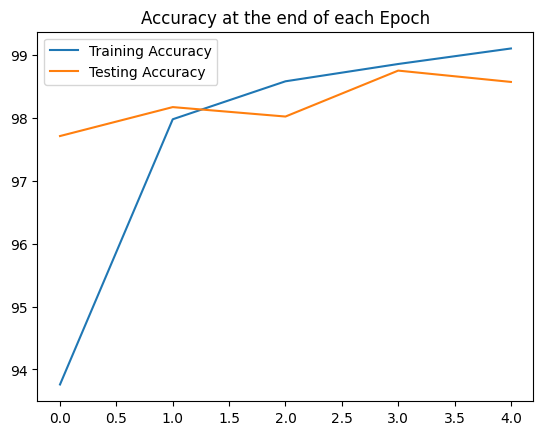

In [212]:
# Graph the accuracy
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the end of each Epoch')
plt.legend()

##### Test Accuracy

In [213]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader:
    y_val = model(X_test)

    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [214]:
print(f'Test Accuracy: {round(correct.item()/len(test_data) * 100, 2)}%')

Test Accuracy: 98.57%


##### Test on New Images

In [215]:
# Taking an Test Image 1
test_image1 = test_data[4143][0]

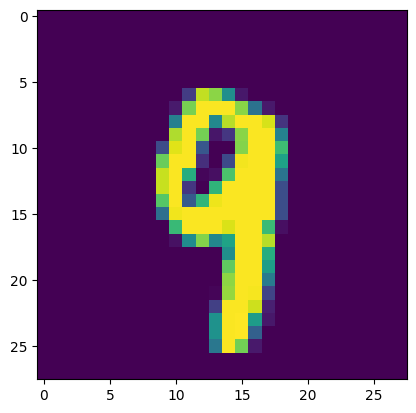

In [216]:
plt.imshow(test_image1.reshape(28, 28))

In [217]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output = model(test_image1.view(1, 1, 28, 28))

In [218]:
# Check the new prediction
output.argmax()

tensor(9)

In [219]:
# Taking an Test Image 2
test_image2 = test_data[1978][0]

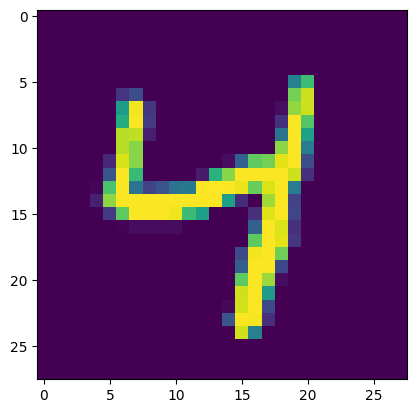

In [220]:
plt.imshow(test_image2.reshape(28, 28))

In [221]:
# New Prediction: Passing the image through our model
model.eval()

with torch.no_grad():
  output2 = model(test_image2.view(1, 1, 28, 28))

In [223]:
# Check the new prediction
output2.argmax()

tensor(4)